In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from scipy.special import gamma
from scipy.integrate import odeint

# Rand reps, model init fixed

In [2]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [3]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [4]:
gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/notebooks/rand_reps/rand_reps_burv_doublenoise.npy')
kept_runs = [0,2,3,4,5,6,7,8,9]
gan_reps = gan_reps[kept_runs, :]

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/burv/burv_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/burv/burv_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/burv/burv_rand_reps_huber.npy')

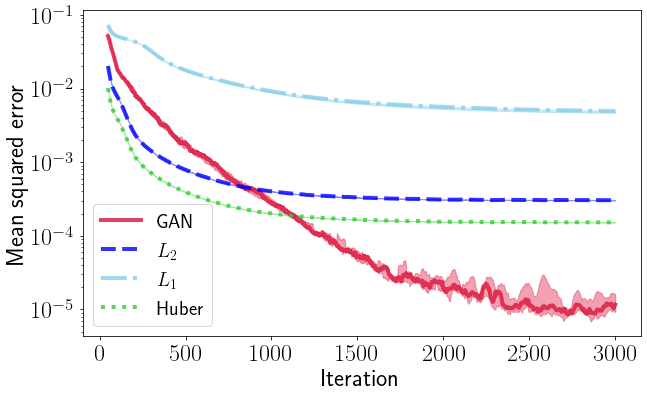

In [6]:
arrs_dict = {"GAN": gan_reps, 
             "$L_2$": l2_reps,
             "$L_1$": l1_reps, 
             "Huber": huber_reps,
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="burv_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [11]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.004511340521275997
L2 Min: 0.00029690337497387573
Huber Min: 0.0001480587882313486
GAN Min: 4.091617985241308e-06


# Finite Diff

In [41]:
def get_exact_dt(delta_x, delta_t, dx, N):
    dt = ((delta_x*delta_t + delta_t*dx) / (N*dx - delta_x - dx))
    return dt

In [63]:
xmin, xmax = -5, 5
tmin, tmax = 0, 2.5
delta_x = xmax - xmin
delta_t = tmax - tmin
dx = 1/4
dt = get_exact_dt(delta_x=delta_x, delta_t=delta_t, dx=dx, N=65**2)

nx = int((delta_x)/dx) + 1
nt = int((delta_t)/dt) + 1
print(nx*nt, 65**2)

4223 4225


In [44]:
nu=0.001
u = np.zeros((nx,nt)) 

# initial condition
def initial_cond(x):
    val = 1 / np.cosh(x)
    return val

for x in range(0,nx):
    u[x,0]=initial_cond(xmin+x*dx)

#simulate dynamics
for t in range(0,nt-1):
    for x in range(1,nx-1):
        u[x,t+1] = nu*((u[x-1,t]-2*u[x,t]+u[x+1,t]) / (2*dx**2))*dt - u[x,t]*((-u[x-1,t]+u[x+1,t]) / (2*dx))*dt + u[x,t]

In [45]:
x = np.linspace(xmin, xmax, nx)
t = np.linspace(tmin, tmax, nt)
xx, tt = np.meshgrid(x, t)

In [46]:
xx.shape, tt.shape, u.shape

((103, 41), (103, 41), (41, 103))

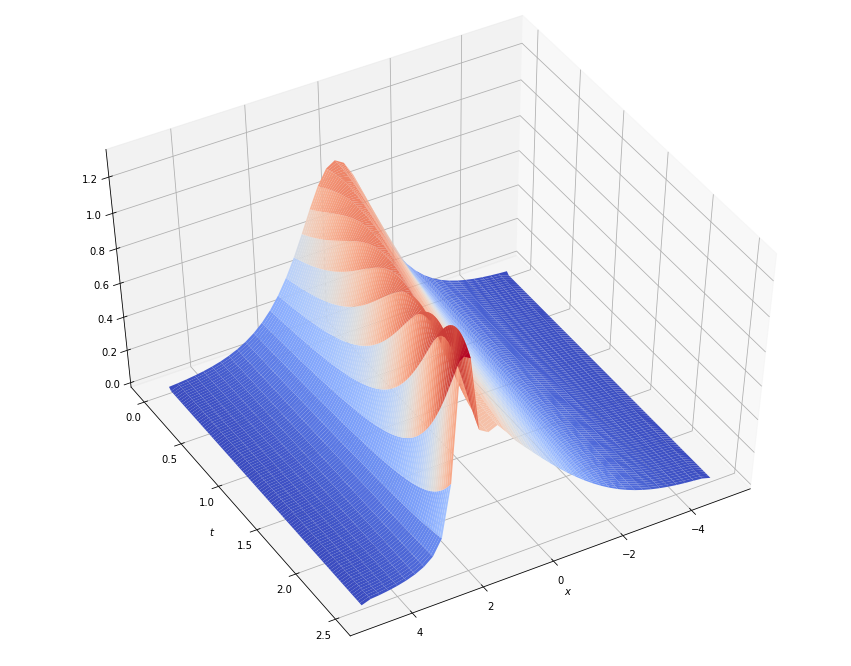

In [47]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, tt, u.T, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.view_init(elev=50, azim=60)
plt.show()

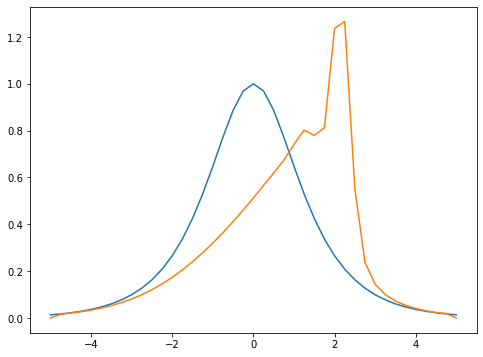

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, u[:,0])
ax.plot(x, u[:,-1])
plt.show()

# Fast Fourier Transform

In [49]:
def fft_burgers(x, t, nu):

    xmin, xmax = np.min(x), np.max(x)
    nx, nt = len(x), len(t)
    dx = (xmax - xmin)/nx

    kappa = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    u0 = 1/np.cosh(x)

    def rhsBurgers(u, t, kappa, nu):
        uhat = np.fft.fft(u)
        d_uhat = (1j)*kappa*uhat
        dd_uhat = -np.power(kappa, 2)*uhat
        d_u = np.fft.ifft(d_uhat)
        dd_u = np.fft.ifft(dd_uhat)
        du_dt = -u*d_u + nu*dd_u
        return du_dt.real

    u = odeint(rhsBurgers, u0, t, args=(kappa, nu))

    return u

In [56]:
x_fine = np.linspace(-5,5,(nx-1)*16+1)
y_fine = np.linspace(0,2.5,nt)
x_fine_grid, y_fine_grid = np.meshgrid(x_fine, y_fine)
u_fine = fft_burgers(x_fine, y_fine, 0.001)

In [57]:
x_fine_grid.shape, y_fine_grid.shape, u_fine.shape

((103, 641), (103, 641), (103, 641))

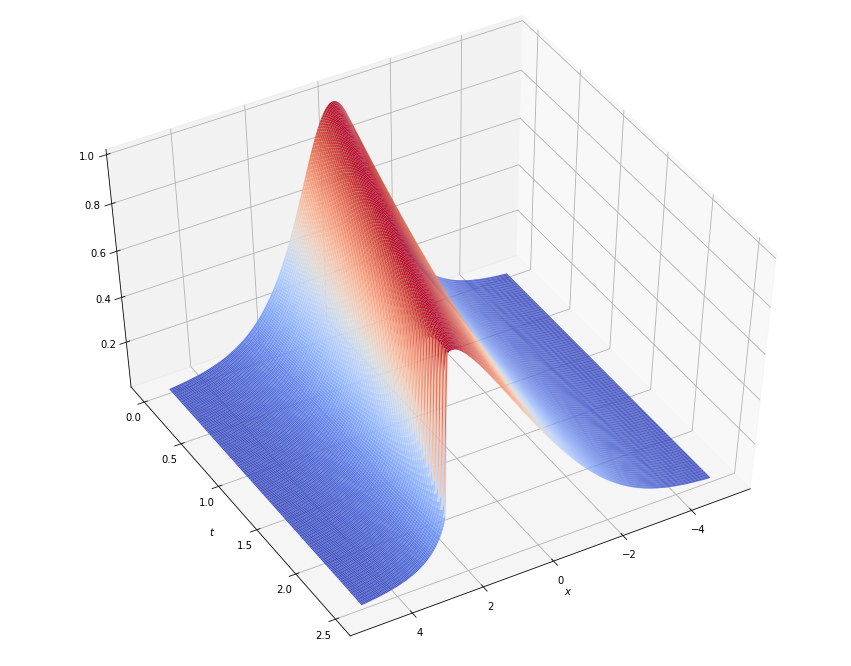

In [58]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x_fine_grid, y_fine_grid, u_fine, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.view_init(elev=50, azim=60)
plt.show()

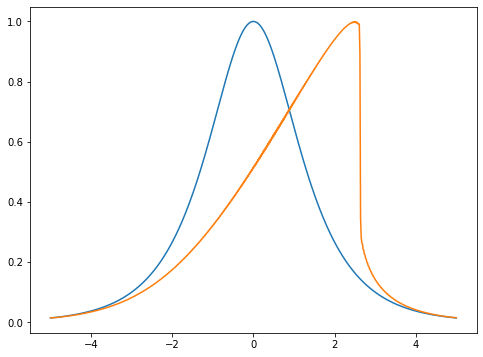

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_fine, u_fine.T[:,0])
ax.plot(x_fine, u_fine.T[:,-1])
plt.show()

In [60]:
u.T.shape, u_fine[:,::16].shape

((103, 41), (103, 41))

In [61]:
print(x_fine[::16])
print(x)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.  ]
[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75  5.  ]


In [62]:
np.mean((u.T - u_fine[:,::16])**2)

0.0016906328919315088